In [33]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [2]:
BATCH_SIZE = 32
EPOCHS = 30
learning_rate = 1e-4
IMG_SIZE = (224, 224)

In [3]:
data = np.load('./processed-data/data.npy')
labels = np.load('./processed-data/labels.npy')

In [4]:
(train_data, test_data, train_label, test_label) = train_test_split(data, labels, test_size=0.1)

(train_data, validation_data, train_label, validation_label) = train_test_split(train_data, train_label, test_size=0.2)

In [5]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [6]:
IMG_SHAPE = IMG_SIZE + (3, )

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=IMG_SHAPE)

base_model.trainable = False

In [7]:
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

In [8]:
model = Model(inputs=base_model.input, outputs=head_model)

In [9]:
model.compile(optimizer=Adam(lr=learning_rate, decay=learning_rate / EPOCHS), loss="binary_crossentropy", metrics=["accuracy"])

In [10]:
fitted_model = model.fit(
                        aug.flow(train_data, train_label, batch_size=BATCH_SIZE),
                        steps_per_epoch=len(train_data) // BATCH_SIZE,
                        validation_data=(validation_data, validation_label),
                        epochs=EPOCHS)

Epoch 1/30
206/206 [==============================] - 112s 545ms/step - loss: 0.2475 - accuracy: 0.8969 - val_loss: 0.0877 - val_accuracy: 0.9715
Epoch 2/30
206/206 [==============================] - 117s 569ms/step - loss: 0.1192 - accuracy: 0.9566 - val_loss: 0.0639 - val_accuracy: 0.9818
Epoch 3/30
206/206 [==============================] - 120s 581ms/step - loss: 0.0938 - accuracy: 0.9641 - val_loss: 0.0552 - val_accuracy: 0.9837
Epoch 4/30
206/206 [==============================] - 119s 575ms/step - loss: 0.0882 - accuracy: 0.9670 - val_loss: 0.0527 - val_accuracy: 0.9843
Epoch 5/30
206/206 [==============================] - 119s 580ms/step - loss: 0.0784 - accuracy: 0.9720 - val_loss: 0.0514 - val_accuracy: 0.9843
Epoch 6/30
206/206 [==============================] - 118s 573ms/step - loss: 0.0674 - accuracy: 0.9772 - val_loss: 0.0483 - val_accuracy: 0.9849
Epoch 7/30
206/206 [==============================] - 117s 566ms/step - loss: 0.0666 - accuracy: 0.9758 - val_loss: 0.0436 -

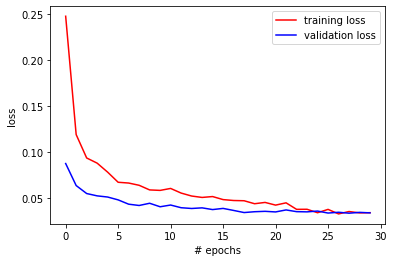

In [11]:
plt.plot(fitted_model.history['loss'], 'r', label='training loss')
plt.plot(fitted_model.history['val_loss'], 'b', label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig("plots/loss-plot.png")
plt.show()

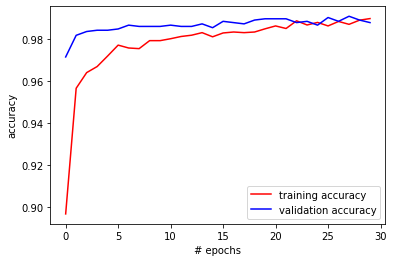

In [12]:
plt.plot(fitted_model.history['accuracy'],'r',label='training accuracy')
plt.plot(fitted_model.history['val_accuracy'], 'b', label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig("plots/accuracy-plot.png")
plt.show()

In [30]:
dict_res = model.evaluate(test_data, test_label)

29/29 [==============================] - 9s 305ms/step - loss: 0.0755 - accuracy: 0.9728


In [31]:
dict_res

[0.07550669461488724, 0.9727668762207031]

In [16]:
model.save('face-mask-detector.h5')

In [6]:
model = load_model('face-mask-detector.h5')

In [26]:
test_predictions = model.predict(test_data, batch_size=BATCH_SIZE)

In [27]:
type(test_predictions)

numpy.ndarray

In [28]:
test_predictions

array([[1.0000000e+00, 1.4872071e-08],
       [1.0000000e+00, 1.7942085e-08],
       [9.9999928e-01, 6.9579283e-07],
       ...,
       [9.1664994e-01, 8.3350144e-02],
       [9.9468488e-01, 5.3151031e-03],
       [1.0000000e+00, 2.1171156e-09]], dtype=float32)

In [29]:
test_predictions = np.argmax(test_predictions, axis=1)

In [32]:
from sklearn.metrics import classification_report

print(classification_report(test_label.argmax(axis=1), test_predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       596
           1       0.98      0.98      0.98       322

    accuracy                           0.99       918
   macro avg       0.98      0.98      0.98       918
weighted avg       0.99      0.99      0.99       918

